# Building Applications to Assess Patient Readmission Risk

## Introduction
This notebook uses a dataset of over 100,000 patient admissions to develop models that assign a risk score for early readmission. It uses Turi's GraphLab Create product to automate several mundane tasks in model building. The notebook then deploys a model as a real-time service using Turi's Predicitive Services.

There are four steps involved with accomplishing this task:
1. Load the data and analyze it using a sketch summary
2. Build a baseline model using GraphLab Create's toolkits
3. Build a more advanced model using feature engineering and model selection
4. Deploy as a real-time service

### Load GraphLab Create
Before we get started we load Turi's GraphLab library. You can download a 30-day free trial of GraphLab Create [here.](https://turi.com/download/)

Turi has also partnered with the University of Washington to create a six-part online [Coursera Machine Learning Specialization](https://www.coursera.org/specializations/machine-learning) course that teaches the fundamentals of machine learning and building predictive applications in Python. Students of the course are entitled to a free 12-month academic license.

In [217]:
import graphlab as gl

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

## 1. Load the data and analyze it
### Data Set Information:

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes.

The data is freely available from University of California-Irivne's ML Repository.

There are two files in the directory. The patient data is in 'diabetic_data.csv' and the codes for admission and discharge are in 'IDs_mapping.csv'. The SFrame is a scalable, out-of-core data frame capable of loading 100s of GBs of data for analysis and machine learning on a single laptop, and it can scale to larger datasets from your EHR databse.

In [218]:
patient_sf = gl.SFrame('patientReadmissionWebinar.sf/')

GraphLab Create's Canvas provides a sketch summary of the patient data.

In [219]:
gl.canvas.set_target('browser')
patient_sf.show()

Canvas is accessible via web browser at the URL: http://localhost:58811/index.html
Opening Canvas in default web browser.


## 2. Build the baseline model
In order to build a model we need three things: the patient data, the features we want to train on, and the target for our model to predict. We use all the features of the data except for the readmission column, the encounter ID and the patient number. We also create a target column for early readmission, defined as any patient that gets readmitted within 30 days.

In [220]:
features = patient_sf.column_names()
features.remove('readmitted')
features.remove('encounter_id')
features.remove('patient_nbr')

patient_sf['early_readmission'] = patient_sf['readmitted'].apply(lambda x: 
                                                                 'readmitted' if x=='<30' 
                                                                 else 'otherwise')

To build the model we randomly split our data into training and test. We then use GraphLab Create's classifier toolkit to auto-select a baseline model. The toolkit automatically uses the numeric data and uses one-hot encoding on the categorical features.

In [221]:
train, test = patient_sf.random_split(0.8, seed = 11)

baseline_model = gl.logistic_classifier.create(train, target='early_readmission', features=features)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



WARNING: Detected extremely low variance for feature(s) 'examide', 'citoglipton' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

Logistic regression:

--------------------------------------------------------

Number of examples          : 77022

Number of classes           : 2

Number of feature columns   : 47

Number of unpacked features : 47

Number of coefficients    : 2150

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 4        | 0.000006  | 0.642661     | 0.888928          | 0.891972            |

| 2         | 8        | 3.000000  | 1.224367     | 0.889097          | 0.891972            |

| 3         | 9        | 3.000000  | 1.417752     | 0.888967          | 0.891972            |

| 4         | 11       | 1.000000  | 1.812672     | 0.889330          | 0.891972            |

| 5         | 12       | 1.000000  | 2.028343     | 0.889629          | 0.891972            |

| 6         | 13       | 1.000000  | 2.354459     | 0.889707          | 0.891972            |

| 10        | 17       | 1.000000  | 3.172848     | 0.890343          | 0.891480            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

We can build trust in our model by first looking at the coefficients. We add the domain meaning to the diagnosis codes as well.

In [222]:
baseline_model

Class                         : LogisticClassifier

Schema
------
Number of coefficients        : 2150
Number of examples            : 77022
Number of classes             : 2
Number of feature columns     : 47
Number of unpacked features   : 47

Hyperparameters
---------------
L1 penalty                    : 0.0
L2 penalty                    : 0.01

Training Summary
----------------
Solver                        : lbfgs
Solver iterations             : 10
Solver status                 : TERMINATED: Iteration limit reached.
Training time (sec)           : 3.2453

Settings
--------
Log-likelihood                : 24250.7037

Highest Positive Coefficients
-----------------------------
diag_2[Disorders of iris and ciliary body]: 9.1183
diag_2[Coccidioidomycosis]    : 7.9505
diag_3[Other congenital anomalies of upper alimentary tract]: 7.8896
diag_3[Dislocation of ankle]  : 7.7463
diag_1[Disorders of carbohydrate transport and metabolism]: 7.5583

Lowest Negative Coefficients
---------------

Many of the features above are specifically related to the diagnosis of the physician. However there are other features of this model that drive the results of this model. Here we exclude the diagnosis codes from our list.

In [223]:
coef = baseline_model.coefficients
diagnosis = ['diag_' + str(x) for x in range(1,4)]
non_diag_coef = coef.filter_by(diagnosis,'name',exclude=True)

non_diag_coef = non_diag_coef.sort('value', ascending=False)
non_diag_coef['name','index','value'].print_rows(num_rows=5)
non_diag_coef = non_diag_coef.sort('value', ascending=True)
non_diag_coef['name','index','value'].print_rows(num_rows=5)

+-----------------------+--------------------------------+---------------+
|          name         |             index              |     value     |
+-----------------------+--------------------------------+---------------+
|   medical_specialty   |            Resident            | 6.40581762959 |
| discharge_disposition | Still patient or expected ...  | 2.63492869936 |
|        miglitol       |              Down              | 1.83646812906 |
|   medical_specialty   | Pediatrics-Hematology-Oncology | 1.63633337055 |
| discharge_disposition | Discharged/transferred/ref...  | 1.62476981432 |
+-----------------------+--------------------------------+---------------+
[222 rows x 3 columns]

+--------------------------+----------------------+----------------+
|           name           |        index         |     value      |
+--------------------------+----------------------+----------------+
| glimepiride-pioglitazone |        Steady        | -5.36675909403 |
|      acetohexamide     

With the model we can evaluate its performance on the holdout set. Although the model is highly accurate, it is actually a result of the sparseness and target imbalance in the dataset.

In [224]:
results = baseline_model.evaluate(test)
print "accuracy: %g, precision: %g, recall: %g, c-stat: %g" % (results['accuracy'], results['precision'], results['recall'], results['auc'])

accuracy: 0.88404, precision: 0.391304, recall: 0.0266723, c-stat: 0.647709


The model has an accuracy of 88%, but has a precision of ~40%. Furthermore it only recalls ~3% of the readmitted patients. What does this mean for the provider? We make a few assumptions and then calculate the percentage of readmission cases that could be avoided through intervention with the riskiest patients, as defined by the model.

**Assumption**
- 65% of all readmissions are avoidable

In [225]:
def get_readmission_pct(patients, model, pct_intervene):
    # assumptions
    preventable_readmission_rate = 0.65
    pct_intervene = pct_intervene/100.0
    
    #model evaluation, sorting, and subsetting
    sorted_patients = gl.SFrame()
    sorted_patients['early_readmission'] = patients['early_readmission']
    sorted_patients['early_readmit_score'] = model.predict(patients, 
                                                           output_type='probability')
    sorted_patients = sorted_patients.sort('early_readmit_score', 
                                           ascending=False)
    sorted_patients = sorted_patients[:int(len(sorted_patients)*pct_intervene)]
    
    number_of_readmits = len(patients[patients['early_readmission']=='readmitted'])
    number_of_readmits_intervened = len(sorted_patients[sorted_patients['early_readmission']=='readmitted'])
    preventable_readmits_intervened = number_of_readmits_intervened*preventable_readmission_rate
    return (number_of_readmits - preventable_readmits_intervened)/float(number_of_readmits)*100

In [226]:
intervene_rate = [x for x in range(0,30,5)]
baseline_readmission_rate = [get_readmission_pct(test, baseline_model, x) for x in intervene_rate]

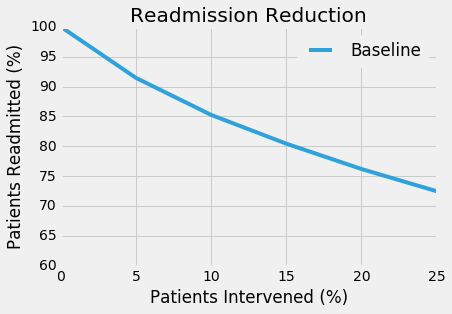

In [227]:
plt.plot(intervene_rate, baseline_readmission_rate)
plt.ylim((60,100))
plt.xlabel('Patients Intervened (%)')
plt.ylabel('Patients Readmitted (%)')
plt.title('Readmission Reduction')
plt.legend(['Baseline'])

## 2. Build an advanced model
One way to gain a better understanding of the data is to analyze the unstructured data within the patients' records. Here we build features into the ICD-9 diagnosis codes to help the model understand similarities between codes.

In [228]:
tfidf = gl.feature_engineering.TFIDF(features=['diag_1','diag_2','diag_3'])
fit_tfidf = tfidf.fit(train)
transformed_train = fit_tfidf.transform(train)
transformed_test = fit_tfidf.transform(test)

In [229]:
transformed_train.show()

Canvas is accessible via web browser at the URL: http://localhost:58811/index.html
Opening Canvas in default web browser.


We now remove a few more features that are likely not contributing to the readmission - weight (because the data is mostly missing) and payer_code.

In [230]:
features = transformed_train.column_names()
features.remove('readmitted')
features.remove('early_readmission')
features.remove('encounter_id')
features.remove('patient_nbr')
features.remove('weight')
features.remove('payer_code')

In [ ]:
for f in ['diag_1', 'diag_2', 'diag_3']:
    features.remove(f)

In the advanced model we specifically use a Boosted Tree classifier. We also choose to weigh the classes by their prevalance in the training data.

In [231]:
gbt_model = gl.boosted_trees_classifier.create(transformed_train, 
                                               target='early_readmission', 
                                               features=features, max_depth=6, early_stopping_rounds=5,
                                               class_weights='auto', metric=['auc', 'log-loss'], max_iterations=100)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



WARNING: Detected extremely low variance for feature(s) 'examide', 'citoglipton' because all entries are nearly the same.
Proceeding with model training using all features. If the model does not provide results of adequate quality, exclude the above mentioned feature(s) from the input dataset.

WARNING: Ignore unsupported tracking metric log-loss

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 77048

Number of classes           : 2

Number of feature columns   : 45

Number of unpacked features : 2949

+-----------+--------------+--------------+----------------+

| Iteration | Elapsed Time | Training-auc | Validation-auc |

+-----------+--------------+--------------+----------------+

| 1         | 0.245458     | 0.669411     | 0.681436       |

| 2         | 0.459935     | 0.676053     | 0.684928       |

| 3         | 0.654589     | 0.678874     | 0.687238       |

| 4         | 0.903505     | 0.681673     | 0.687223       |

| 5         | 1.131491     | 0.686478     | 0.689299       |

| 6         | 1.339973     | 0.689203     | 0.691389       |

| 10        | 2.055081     | 0.703546     | 0.695965       |

| 11        | 2.316759     | 0.704658     | 0.695534       |

| 15        | 3.017556     | 0.713737     | 0.697832       |

| 20        | 3.843351     | 0.724249     | 0.693578       |

+-----------+--------------+--------------+----------------+

Early stop triggered. Returning the best model at iteration: 15

In [233]:
results = gbt_model.evaluate(transformed_test)
print "accuracy: %g, precision: %g, recall: %g, c-stat: %g" % (results['accuracy'], results['precision'], results['recall'], results['auc'])

accuracy: 0.64143, precision: 0.178753, recall: 0.594835, c-stat: 0.670616


In [234]:
gbt_model.get_feature_importance()

name,index,count
num_lab_procedures,None,40
number_inpatient,None,29
num_medications,None,27
time_in_hospital,None,24
discharge_disposition,Expired,23
number_diagnoses,None,19
number_emergency,None,13
discharge_disposition,Discharged/transferred toanother rehab fac ...,11
discharge_disposition,Discharged to home,10
discharge_disposition,Discharged/transferred toSNF ...,8


In [237]:
gbt_readmission_rate = [get_readmission_pct(transformed_test, gbt_model, x) for x in intervene_rate]

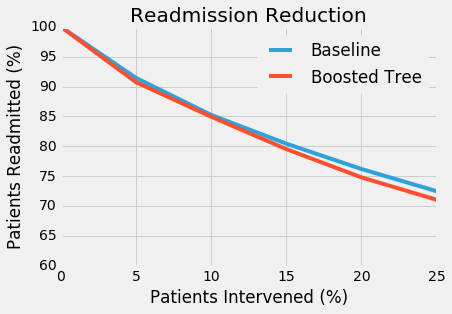

In [238]:
plt.plot(intervene_rate, baseline_readmission_rate, intervene_rate, gbt_readmission_rate)
plt.ylim((60,100))
plt.xlabel('Patients Intervened (%)')
plt.ylabel('Patients Readmitted (%)')
plt.title('Readmission Reduction')
plt.legend(['Baseline','Boosted Tree'])

## 4. Deploy as a real-time service
The first step in integrating the application is to understand the pateints most likely to be readmitted. This will give the provider and they payer a sense of confidence in who to reach out to for proactive care.

In [241]:
transformed_test['early_readmit_score'] = gbt_model.predict(transformed_test,output_type='probability')
gbtList = transformed_test.sort('early_readmit_score', ascending=False)
gbtList['early_readmit_score', 'number_inpatient','num_lab_procedures','time_in_hospital']

early_readmit_score,number_inpatient,num_lab_procedures,time_in_hospital
0.913433134556,7,27,2
0.900232315063,11,39,4
0.899768650532,12,9,3
0.896917164326,4,43,1
0.894993662834,16,11,2
0.892705321312,12,23,6
0.886688888073,12,40,3
0.883442044258,8,37,2
0.883040249348,9,15,2
0.879513561726,16,17,5


```python
# define the state path - this is where Turi will store the models, logs, and metadata for this deployment
ps_state_path = 's3://turi-neel/predictive_service/patient_readmission_app'


# setup your own AWS credentials.
# gl.aws.set_credentials(<key>,<secret key>)

# create an EC2 config - this is how you define the EC2 configuration for the cluster being deployed
ec2 = gl.deploy.Ec2Config(region='us-west-2', instance_type='m3.xlarge')

# use the EC2 config to launch a new Predictive Service
# num_hosts specifies how many machines the Predictive Service cluster has. 
#     You can scale up and down later after initial creation.

deployment = gl.deploy.predictive_service.create(name = 'neel-patient-readmission-app', 
                                                    ec2_config = ec2, state_path = ps_state_path, num_hosts = 3)
```

In [242]:
ps_state_path = 's3://turi-neel/predictive_service/patient_readmission_app'
deployment = gl.deploy.predictive_service.load(ps_state_path)

[WARNING] graphlab.deploy.predictive_service: Overwriting existing Predictive Service "neel-patient-readmission-app" in local session.


In [243]:
# see the status of and what's deployed on my_deployment
deployment

Name                  : neel-patient-readmission-app
State Path            : s3://turi-neel/predictive_service/patient_readmission_app
Description           : None
API Key               : d2d57a46-721a-4e1e-9046-606394aa8df2
CORS origin           : 
Global Cache State    : enabled
Load Balancer DNS Name: neel-patient-readmission-app-1711156681.us-west-2.elb.amazonaws.com

Deployed endpoints:

No Pending changes.

In [244]:
# inputs and returns of this function map directly to the io of the endpoint for the REST service
def get_readmission_risk(json_row):
    json_row = {key:[value] for key,value in json_row.items()}
    patient_info = fit_tfidf.transform(gl.SFrame(json_row))
    patient_info['early_readmit_score'] = gbt_model.predict(patient_info, output_type='probability')
    return patient_info


In [245]:
deployment.add('patient_readmission_risk', get_readmission_risk)
deployment.apply_changes()

[INFO] graphlab.deploy._predictive_service._predictive_service: Endpoint 'patient_readmission_risk' is added. Use apply_changes() to deploy all pending changes, or continue with other modification.
[INFO] graphlab.deploy._predictive_service._predictive_service: Persisting endpoint changes.
[INFO] graphlab.util.file_util: Uploading local path /var/folders/98/myzp9lp55qz2s1_jlb1l91w40000gn/T/predictive_object_HJWvmY to s3 path: s3://turi-neel/predictive_service/patient_readmission_app/predictive_objects/patient_readmission_risk/1


upload: ../../../../var/folders/98/myzp9lp55qz2s1_jlb1l91w40000gn/T/predictive_object_HJWvmY/8e572f22-9237-46ed-89c9-4dd21d4266da/dir_archive.ini to s3://turi-neel/predictive_service/patient_readmission_app/predictive_objects/patient_readmission_risk/1/8e572f22-9237-46ed-89c9-4dd21d4266da/dir_archive.ini
upload: ../../../../var/folders/98/myzp9lp55qz2s1_jlb1l91w40000gn/T/predictive_object_HJWvmY/pickle_archive to s3://turi-neel/predictive_service/patient_readmission_app/predictive_objects/patient_readmission_risk/1/pickle_archive
upload: ../../../../var/folders/98/myzp9lp55qz2s1_jlb1l91w40000gn/T/predictive_object_HJWvmY/8e572f22-9237-46ed-89c9-4dd21d4266da/m_d340fee66abb221d.frame_idx to s3://turi-neel/predictive_service/patient_readmission_app/predictive_objects/patient_readmission_risk/1/8e572f22-9237-46ed-89c9-4dd21d4266da/m_d340fee66abb221d.frame_idx
upload: ../../../../var/folders/98/myzp9lp55qz2s1_jlb1l91w40000gn/T/predictive_object_HJWvmY/bd2ae25e-cf45-4969-b353-0b9ef3216a21/di

[INFO] graphlab.util.file_util: Successfully uploaded to s3 path s3://turi-neel/predictive_service/patient_readmission_app/predictive_objects/patient_readmission_risk/1


upload: ../../../../var/folders/98/myzp9lp55qz2s1_jlb1l91w40000gn/T/predictive_object_HJWvmY/bd2ae25e-cf45-4969-b353-0b9ef3216a21/objects.bin to s3://turi-neel/predictive_service/patient_readmission_app/predictive_objects/patient_readmission_risk/1/bd2ae25e-cf45-4969-b353-0b9ef3216a21/objects.bin


In [247]:
# Low Scores: 1500, 6000, 13500
# High scores: 7500, 9000, 15000

result = deployment.query('patient_readmission_risk', test[6000])

for response in ['early_readmit_score', 'number_inpatient','num_lab_procedures','time_in_hospital']:
    print response + ': ' + str(result.get('response')[0].get(response))


early_readmit_score: 0.290829002857
number_inpatient: 0
num_lab_procedures: 38
time_in_hospital: 2


In [ ]:
deployment.terminate_service()

## Summary: 
By using Machine Learning on patient data we can prioritize which patients are at risk for readmission and provide clear insights on why a doctor, provider, or payer should be thinking proactively about the individual.

Using Turi's Platform a development team can easily implement a readmission propensity model and deploy it as a REST API for integration into EMR tools and Dashboards

Want to find out more? Let's talk: neel@turi.com

### Source of Data:
The data are submitted on behalf of the Center for Clinical and Translational Research, Virginia Commonwealth University, a recipient of NIH CTSA grant UL1 TR00058 and a recipient of the CERNER data. John Clore (jclore '@' vcu.edu), Krzysztof J. Cios (kcios '@' vcu.edu), Jon DeShazo (jpdeshazo '@' vcu.edu), and Beata Strack (strackb '@' vcu.edu). This data is a de-identified abstract of the Health Facts database (Cerner Corporation, Kansas City, MO).

https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008


#### Citation:
Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014. 